# Machine Learning - Practical 4 - Deep Learning VS Trees

In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [repository](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


In [3]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
torch.manual_seed(42) # Set manual seed

In [4]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Load, clean and split the tabular dataset

We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**    

Remove all rows containing at least one missing entry.    

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity*

**Balanced classes**   

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**   

Remove categorical features with more than 20 items. 

**High cardinality numerical features**   

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Data description:**  
Data reported to the police about the circumstances of personal injury road accidents in Great Britain from 1979. This version includes data up to 2015. We will try to predict the sex of the driver based on the data provided.

In [5]:
## In case you have any issues with loading the pickle file
## check that your pandas version is 1.4.1
## or just simply run:
## pip install pandas==1.4.1

with open('/kaggle/input/adopted-road-safety/adopted_road_safety.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [6]:
type(dataset)
print(dataset.dtypes)
dataset

Accident_Index                        category
Vehicle_Reference_df_res                 int64
Vehicle_Type                           float64
Towing_and_Articulation                float64
Vehicle_Manoeuvre                      float64
                                        ...   
Bus_or_Coach_Passenger                 float64
Pedestrian_Road_Maintenance_Worker     float64
Casualty_Type                            int64
Casualty_Home_Area_Type                float64
Casualty_IMD_Decile                    float64
Length: 67, dtype: object


,Accident_Index,Vehicle_Reference_df_res,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,201501BS70001,1,19.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,7.0,3,5.0,1.0,0.0,0.0,2.0,0,NaN,NaN
1,201501BS70002,1,9.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,5.0,3,9.0,9.0,0.0,0.0,2.0,0,1.0,3.0
2,201501BS70004,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,6.0,3,1.0,3.0,0.0,0.0,2.0,0,1.0,6.0
3,201501BS70005,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,2.0,3,5.0,1.0,0.0,0.0,2.0,0,1.0,2.0
4,201501BS70008,1,1.0,0.0,18.0,0.0,8.0,0.0,0.0,0.0,...,8.0,2,0.0,0.0,0.0,0.0,0.0,1,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363238,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,1.0,3,0.0,0.0,2.0,0.0,0.0,9,1.0,NaN
363239,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,5.0,3,0.0,0.0,0.0,0.0,0.0,9,1.0,2.0
363240,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,4.0,3,0.0,0.0,0.0,0.0,0.0,9,2.0,5.0
363241,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,6.0,3,0.0,0.0,0.0,0.0,0.0,9,3.0,NaN


In [7]:
target_column = 'Sex_of_Driver'
test_size = 0.2
random_state = 42

In [8]:
def remove_nans(df):
    '''
    this fucntion removes rows with nans 
    '''
    # TODO
    df = df.dropna()
    return df


def numerical_to_categorical(df, n=2, ignore=[target_column]):
    '''
    change the type of the column to categorical 
    if it has <= n unique values
    '''
    # TODO
    for column in df.columns:
        if column not in ignore and df[column].nunique() <= n and pd.api.types.is_numeric_dtype(df[column]):
            df[column] = df[column].astype('category')
    
    return df


def remove_columns_by_n(df, n=10, condition=np.number, direction='less', 
                        ignore=[target_column]):
    '''
   
    Remove columns with more or less than n unique values. 
    Usually it makes sense to apply this function to columns with categorical values (see below where it is called).
    With the default values we remove all numerical columns which have less than 10 unique values (except for the target_column).
    '''
    # TODO
    if condition == "category":
        for column in df.columns:
            if column not in ignore and df[column].dtype == "category":
                unique_values = df[column].nunique()
                if direction == 'less' and unique_values < n:
                    df = df.drop(column, axis=1)
                elif direction == 'more' and unique_values > n:
                    df = df.drop(column, axis=1)
    else:
        for column in df.columns:
            if column not in ignore and df[column].dtype != "category":
                unique_values = df[column].nunique()
                if direction == 'less' and unique_values < n:
                    df = df.drop(column, axis=1)
                elif direction == 'more' and unique_values > n:
                    df = df.drop(column, axis=1)
    return df

In [9]:
df = dataset
df = remove_nans(df)
df = numerical_to_categorical(df, n=2, ignore=[target_column])
df = remove_columns_by_n(df, n=10, condition=np.number, direction='less', 
                         ignore=[target_column])
df = remove_columns_by_n(df, n=40, condition='category', direction='more', 
                         ignore=[target_column])
assert not df.isna().any().any(), 'There are still nans in the dataframe'

/tmp/ipykernel_27/1615419110.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category')
/tmp/ipykernel_27/1615419110.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category')
/tmp/ipykernel_27/1615419110.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [10]:
# TODO : make train-test split from the dataframe using the parameters above
# expected results variable names - train_X, test_X, train_y, test_y

X = df.drop(target_column, axis=1)
Y = df[target_column]

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=test_size, random_state = random_state)

**TODO :**  

* Did you split the dataset in a stratified manner or not? Why?
* How did the dataset dimensions change after preprocessing?
* How many unique values are in the response variable? 

## Task 1: Create a GradientBoostingClassifier

In [11]:
## TODO : define the GradientBoostingClassifier, 
## train it on the train set and predict on the test set
model = GradientBoostingClassifier()
model.fit(train_X, train_y)
predictions = model.predict(test_X)


In [12]:
## TODO : print  accuracy, precision, recall
## Hint : use functions from sklearn metrics

accuracy = accuracy_score(test_y, predictions)
precision = precision_score(test_y, predictions, average='weighted')
recall = recall_score(test_y, predictions, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7742655455206062
Precision: 0.7688298858831665
Recall: 0.7742655455206062


In [13]:
## TODO : Write a function which iterates over trees_amount, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
    #TODO
     for n_trees in trees_amount:
        model = GradientBoostingClassifier(n_estimators=n_trees)
        model.fit(train_X, train_y)

        predictions = model.predict(test_X)

        accuracy = accuracy_score(test_y, predictions)
        precision = precision_score(test_y, predictions, average='weighted')
        recall = recall_score(test_y, predictions, average='weighted')

        print(f"Number of Trees: {n_trees}")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)


In [14]:
trees_amount_exploration(train_X, train_y, test_X, test_y)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of Trees: 1
Accuracy: 0.6515623377971557
Precision: 0.42453348003569474
Recall: 0.6515623377971557
Number of Trees: 20
Accuracy: 0.7470154676632409
Precision: 0.7401440585074229
Recall: 0.7470154676632409
Number of Trees: 50
Accuracy: 0.7658050451572719
Precision: 0.7596796423456945
Recall: 0.7658050451572719
Number of Trees: 100
Accuracy: 0.7741617357001972
Precision: 0.7687297468748734
Recall: 0.7741617357001972


In [15]:
## TODO : Write a function which iterates over the learning rate, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=100):
    #TODO
    for learning_rate in learning_rates:
        model = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=trees_amount)
        model.fit(train_X, train_y)

        predictions = model.predict(test_X)

        accuracy = accuracy_score(test_y, predictions)
        precision = precision_score(test_y, predictions, average='weighted')
        recall = recall_score(test_y, predictions, average='weighted')

        print(f"Learning Rate: {learning_rate}")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)

In [16]:
learning_rate_exploration(train_X, train_y, test_X, test_y)

Learning Rate: 0.1
Accuracy: 0.7742655455206062
Precision: 0.7688298858831665
Recall: 0.7742655455206062
Learning Rate: 0.2
Accuracy: 0.7805979445655559
Precision: 0.7761922620387031
Recall: 0.7805979445655559
Learning Rate: 0.3
Accuracy: 0.7754074535451053
Precision: 0.7713874578736348
Recall: 0.7754074535451053
Learning Rate: 0.4
Accuracy: 0.7776912695941036
Precision: 0.773806233543324
Recall: 0.7776912695941036
Learning Rate: 0.5
Accuracy: 0.7829855704349632
Precision: 0.7791704360275685
Recall: 0.7829855704349632


In [17]:
## TODO : Write a function which iterates over different depths, 
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depending on the computer efficiency).

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1,2,3,5]):
    for depth in depths:
        model = GradientBoostingClassifier(max_depth=depth, n_estimators=50)
        model.fit(train_X, train_y)
        predictions = model.predict(test_X)
        accuracy = accuracy_score(test_y, predictions)
        precision = precision_score(test_y, predictions, average='weighted')
        recall = recall_score(test_y, predictions, average='weighted')
        
        print(f"Max Depth: {depth}")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)

In [18]:
max_depth_exploration(train_X, train_y, test_X, test_y)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Max Depth: 1
Accuracy: 0.7465483234714004
Precision: 0.7384618881477107
Recall: 0.7465483234714004
Max Depth: 2
Accuracy: 0.7487802346101942
Precision: 0.7415053444643234
Recall: 0.7487802346101942
Max Depth: 3
Accuracy: 0.7658050451572719
Precision: 0.7596796423456945
Recall: 0.7658050451572719
Max Depth: 5
Accuracy: 0.7836084293574173
Precision: 0.7795913808634742
Recall: 0.7836084293574173


**TODO :**   

* How does the max_depth parameter influence the results? 
* How does the learning rate influence the results?
* How does the number of trees in the ensemble influence the results?
* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform?

In [19]:
## TODO -  sklearn trees have the attribute feature_importances_
## make a plot, to show relative importance (maximum is 1) of your classifier and
## order features from most relevant feature to the least relevant in the plot

def plot_explained_variance(clf, X):
    
    importances = clf.feature_importances_
    sorted_indices = importances.argsort()[::-1]
    sorted_features = X.columns[sorted_indices]
    sorted_importances = importances[sorted_indices]
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), sorted_importances, tick_label=sorted_features)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.xticks(rotation=90)
    plt.show()

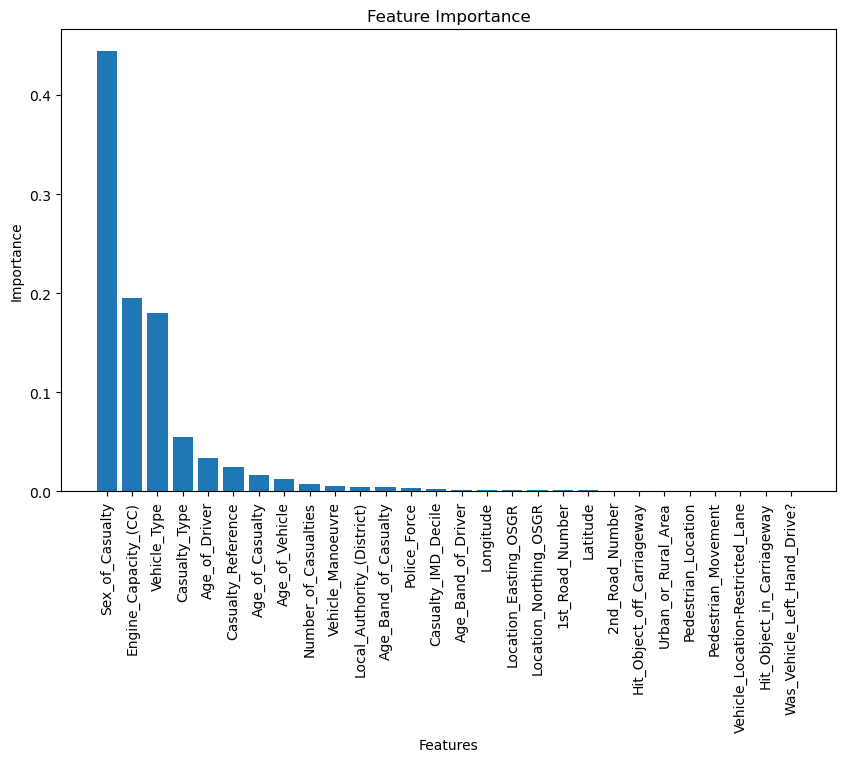

In [20]:
## TODO : display the plot
plot_explained_variance(model, X)


**TODO :** Interpret the plot.

**TODO (optional):** Try to remove the least-important features and see what happens. Does to quality improve or degrade? Why? 